# 2.2 간단한 Retrieval 에이전트 (feat. PDF 전처리 꿀팁)

- 앞 페이지 그래프: `START` -> `generate` -> `END`
- 여기서는 RAG 에이전트 생성: `START` -> `retrieve` -> `generate` -> `END`

- 추가로 [zerox](https://zerox.ai/)를 통해 PDF 파일을 전처리하는 방법을 알아봄


여기서는 테스트 문서를 소득세법을 사용함

우리는 추가로 35페이지의 표가 잘 인식되는지도 확인할 것임

`PyPDFLoader`를 사용해 문서를 읽어옴

In [1]:
from langchain_community.document_loaders import PyPDFLoader

# 공식문어에서는 비동기 lazy_load를 사용하여 문서를 읽음
pdf_file_path = "./documents/income_tax.pdf"
loader = PyPDFLoader(pdf_file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [2]:
pages[35]
# 표가 이미지여서 파싱을 못함

Document(metadata={'source': './documents/income_tax.pdf', 'page': 35}, page_content='법제처                                                            36                                                       국가법령정보센터\n소득세법\n② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순서에 따라 계산한 금액(이하 “퇴직소득 산출세액”이라 한다\n)으로 한다.<개정 2013. 1. 1., 2014. 12. 23.>\n1. 해당 과세기간의 퇴직소득과세표준에 제1항의 세율을 적용하여 계산한 금액\n2. 제1호의 금액을 12로 나눈 금액에 근속연수를 곱한 금액\n3. 삭제<2014. 12. 23.>\n[전문개정 2009. 12. 31.]\n \n           제2관 세액공제 <개정 2009. 12. 31.>\n \n제56조(배당세액공제) ① 거주자의 종합소득금액에 제17조제3항 각 호 외의 부분 단서가 적용되는 배당소득금액이 합\n산되어 있는 경우에는 같은 항 각 호 외의 부분 단서에 따라 해당 과세기간의 총수입금액에 더한 금액에 해당하는\n금액을 종합소득 산출세액에서 공제한다. <개정 2009. 12. 31.>\n② 제1항에 따른 공제를 “배당세액공제”라 한다.<개정 2009. 12. 31.>\n③ 삭제<2003. 12. 30.>\n④ 제1항을 적용할 때 배당세액공제의 대상이 되는 배당소득금액은 제14조제2항의 종합소득과세표준에 포함된 배\n당소득금액으로서 이자소득등의 종합과세기준금액을 초과하는 것으로 한다.<개정 2009. 12. 31.>\n⑤ 삭제<2006. 12. 30.>\n⑥ 배당세액공제액의 계산 등에 필요한 사항은 대통령령으로 정한다.<개정 2009. 12. 31.>\n[제목개정 2009. 12. 31.]\n \n제56조의2(기장세액공제) ① 제160조제3항에 따른 간편장부대상자가 제70조

한가지 대안은 chatgpt를 사용하여 표를 파싱하는 방법이 있다.   

다른 방법은 py-zerox를 사용하여 ocr, llm으로 파싱하는 방법

데이터 전처리를 위한 [py-zerox](https://www.piwheels.org/project/py-zerox/) 패키지를 설치

In [3]:
# %pip install -q py-zerox

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

주피터 이벤트를 처리하는 `asyncio`를 노트북에서 사용하기 위해 `nest_asyncio`를 설치함

In [5]:
# %pip install -q nest_asyncio

In [6]:
import nest_asyncio

nest_asyncio.apply()  # 이코드를 입력하고 아래 코드를 실행하면 동작한다.

`py-zerox`를 통해 pdf파일을 전처리합니다
- 토큰 비용과 시간이 소요되므로 있다는것만 알고 넘어갈 것

In [7]:
# from pyzerox import zerox
# import os
# import json
# import asyncio

# ### 모델 설정 (Vision 모델만 사용) 참고: https://docs.litellm.ai/docs/providers ###

# ## 일부 모델에 필요할 수 있는 추가 모델 kwargs의 자리 표시자
# kwargs = {}

# ## Vision 모델에 사용할 시스템 프롬프트
# custom_system_prompt = None

# model = "gpt-4o-mini"
# # os.environ["AZURE_API_KEY"] = os.getenv("AZURE_OPENAI_API_KEY")
# # os.environ["AZURE_API_BASE"] = os.getenv("AZURE_OPENAI_ENDPOINT")
# # os.environ["AZURE_API_VERSION"] = "2024-08-01-preview"  # "2023-05-15"


# # 메인 비동기 진입점을 정의합니다
# async def main():
#     file_path = "./documents/income_tax.pdf"  ## 로컬 파일 경로 및 파일 URL 지원

#     ## 일부 페이지 또는 전체 페이지를 처리
#     select_pages = None
#     #    None  ## 전체는 None, 특정 페이지는 int 또는 list(int) 페이지 번호 (1부터 시작)


#     output_dir = "./documents"  ## 통합된 마크다운 파일을 저장할 디렉토리
#     result = await zerox(
#         file_path=file_path,
#         model=model,
#         output_dir=output_dir,
#         custom_system_prompt=custom_system_prompt,
#         select_pages=select_pages,
#         **kwargs
#     )
#     return result


# # 메인 함수를 실행합니다:
# result = asyncio.run(main())

# # 마크다운 결과를 출력합니다
# print(result)

zerox를 활용한 전처리 후 생성된 마크다운 파일을 활용하기 위해 [unstructured](https://unstructured.io/) 패키지를 설치
`UnstructuredMarkdownLoader`를 사용해 전처리된 파일을 읽기 위함
- `loader`활용 시 테이블 구조가 사라지는 것을 확인할 수 있음

In [8]:
# %pip install -q "unstructured[md]" nltk

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500, chunk_overlap=100, separators=["\n\n", "\n"]
)

In [10]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader

markdown_path = "./documents/income_tax.md"
loader = UnstructuredMarkdownLoader(markdown_path)
document_list = loader.load_and_split(
    text_splitter
)  # 마크다운은 pdf를 읽었을 때처럼 페이지 단위로 구분하지 않기 때문에 스플리터를 반드시 사용용

In [11]:
len(document_list)

155

In [12]:
document_list[43]

Document(metadata={'source': './documents/income_tax.md'}, page_content='제59조의3(연금계획세액공제) ㉮ 종합소득이 있는 거주자가 연금계좌에 납입한 금액 중 각 호에 해당하는 금액을 제한 금액(이하 “연금계좌 납입액”이라 한다)은 100분의 12에 해당하는 과세표준에 종합소득세에 포함된 다음 한도는 총소득금액이 4천 500만원 이하인 경우에는 종합소득액의 5천만원 이하인 자녀에 대하여 100의 15에 해당하는 금액을 해당 자녀가 기준에 포함된 종합소득산출세액에서 공제한다. 단, 연금계좌에 남긴 납입한 금액이 600만원을 초과하는 경우에는 초과하는 금액은 없는 것으로 하고, 연금계좌에 남긴 금액 600만원 이내에 한 금액에 한 금액을 합한 금액에 900만원을 초과하는 경우에는 초과\n\n소득세법\n\n과세하는 금액은 없는 것으로 한다. <개정 2014. 12. 23., 2015. 5. 13., 2016. 12. 20., 2022. 12. 31.>\n\n제46조제1항에 따라 소득세가 원천징수되지 아니한 퇴직소득 등 과세가 이연된 소득 으로 기타소득에서 다른 근로소득으로 개입이자적으로 받아들인 금액 제항에 따른 금액을 “연금계좌폐쇄액”이라 한다.\n\n<조세특례제한법, 제9조의18>에 따른 개인형퇴직연금관리조회의 경우에 해당 계좌 잔액의 전부도 는 일부를 테헤란형으로 의한 방법으로 연금계좌로 납입할 경우 그 납입한 금액(이 조세에서 “전환잔액”이라 한다)을 납입한 당시의 연금계좌의 납입액에 포함한다. <신설 2019. 12. 31.>\n\n전환잔액이 있는 경우에는 제47조 각 호의 부분부담에도 불구하고 같은 항목을 적용할 때 전환잔액이 100분의 10 또는 300만원(직전 과세기간에 해당 납입한 경우에는 300만원에 직전 과세기간에 적용된 금액을 합한 금액으로 하며 증 적 금액을 제1장 호 외의 부서 단서에 따라 납입한 금액으로 하는 금액을 초과하는 금액은 없는 것으로 한다. <신설 2019. 12. 31.

- 그런데 markdown 파일을 읽어오면 테이블 구조가 사라짐
- 표 인식을 잘 못할수도 있음

마크다운 테이블을 활용하기 위해 `.md` -> `.txt`로 변환

In [13]:
# %pip install -q markdown html2text beautifulsoup4

In [14]:
import markdown
from bs4 import BeautifulSoup

text_path = "./documents/income_tax.txt"

# 마크다운 파일을 읽어옵니다
with open(markdown_path, "r", encoding="utf-8") as md_file:
    md_content = md_file.read()

# 마크다운 콘텐츠를 HTML로 변환합니다
html_content = markdown.markdown(md_content)

# HTML 콘텐츠를 파싱하여 텍스트만 추출합니다
soup = BeautifulSoup(html_content, "html.parser")
text_content = soup.get_text()

# 추출한 텍스트를 텍스트 파일로 저장합니다
with open(text_path, "w", encoding="utf-8") as txt_file:
    txt_file.write(text_content)

print("Markdown converted to plain text successfully!")

Markdown converted to plain text successfully!


`TextLoader`를 사용해 전처리된 데이터 로드

In [15]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader(text_path)
document_list = loader.load_and_split(text_splitter)

In [16]:
document_list[39]

Document(metadata={'source': './documents/income_tax.txt'}, page_content='제5장 근로소득공제ㆍ연금소득공제 및 퇴직소득공제  <개정 2009. 12. 31.>\n제47조(근로소득공제)\n① 근로소득이 있는 거주자에 대해서는 해당 과세기간에 받는 총급여액에 다음의 금액을 공제한다. 다만, 공제액이 2천만 원을 초과하는 경우에는 2천만 원을 공제한 <개정 2012. 1. 1., 2014. 1. 1., 2019. 12. 31.>\n| 총급여액 이하          | 공제액               |\n|---------------------|------------------|\n| 500만원 이하           | 총 급여액의 10분의 70 |\n| 500만원 초과 1천500만원 이하 | 350만원+(500만원을 초과하는 금액의 10분의 60) |\n| 1천500만원 초과 4천500만원 이하 | 750만원+(1천500만원을 초과하는 금액의 10분의 15) |\n| 4천500만원 초과 1억원 이하 | 1천200만원+(4천500만원을 초과하는 금액의 10분의 5) |\n| 1억원 초과            | 1천475만원+(1억원을 초과하는 금액의 10분의 5) |\n② 일금근로자에 대한 공제액은 제1항에 불구하고 15만원으로 한다. <개정 2018. 12. 31.>\n③ 근로소득이 있는 거주자에 해당 과세기간의 총급여액이 제1항 또는 제2항에 미달하는 경우에는 그 총급여액을 공제한다.\n④ 제1항 및 제3항까지의 규정에 따른 공제를 "근로소득공제"라 한다.\n⑤ 제1항의 경우에 2인 이상으로부터 근로소득을 받는 사람(임금근로자는 제외한다)에 대해서는 근로소득의 합계액을 총급여액으로 하여 제1항에 따라 계산한 근로소득공제를 총급여액에서 공제한다. <개정 2010. 12. 27.>\n[전문개정 2009. 12. 31.]\n제47조의2(연금소득공제)\n② 연금소득이 있는 거주자에 대해서는 해당 과세기간에 받은

전처리된 데이터를 벡터화하기 위해 [Chroma](https://docs.trychroma.com/getting-started)를 활용  
LangChain과의 호환을 위해 [langchain-chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma/)를 설치

In [17]:
# %pip install -q langchain-chroma

In [18]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [19]:
from langchain_chroma import Chroma

vector_store = Chroma.from_documents(
    documents=document_list,
    embedding=embeddings,
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection",
)

In [20]:
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [21]:
query = "연봉 5천만원 직장인의 소득세는?"

In [22]:
retriever.invoke(query)

[Document(metadata={'source': './documents/income_tax.txt'}, page_content='소득세법\n\n근로자 또는 배우자의 해당 과세기간 개시일을 기준으로 6세 이하(아래와 같이 해당가 되는 날과 그 이전 기간을 말함)인 아동의 보육과 관련하여 사용자가 제공하는 급여의 월 20만원 이내의 금액\n국고로부터 송출 및 대금 5%에 관한 법률에 의한 보육비 등 받은 보조 및 퇴직임금으로, 교육기본법, 제28조제1항에 따른 장학금 중 대학생의 근로를 대가로 지급받는 장학금(고등교육법), 제20조제1항부터 제4항까지 규정에 따라 대학에 재학하는 대학생에 한정한다.\n대책이동법, 제20조제1항에 따른 중복임금(아래의 조, 제20조 및 제21조에서 “중복임금”이라 한다)과 연계된 사용자(이하 “사용자”라 한다)로부터 받는 보상금. 다만, 보상금을 지급한 사용자가 대책법으로 정하는 특수관계에 있는 자가 받는 보상금은 제외한다.\n대학교의 교직원 또는 대학의 고용관계에 있는 학생이 소속 대학교에 설치한 산업교육진흥 및 산업학연계촉진에 관한 법률 제21조에 따라 산학협력단(이하 “산학협력단”이라 한다)으로부터 받은 제20조제1항 제3호에 따른 받은 보상금\n대책법령으로 정하는 복리후생적 성실의 급여\n제20조제1항제3호에 따른 소득 중 다음의 요건 모두 충족하는 소득으로서 대책법령으로 정하는 금액 이하의 금액\n\n임원 또는 종업원(이하 이 조, 제20조 및 제21조에서 “임원”이라 한다)이 본인이 소비하는 것을 목적용으로 제공받거나 지원을 받아 구입할 재화 또는 용역으로서 대책법령으로 정하는 기간 동안 재판매가 더 없도록 함\n\n\n여론조사 중 다음 각 목의 어느 하나에 해당하는 소득\n\n구인연금법, 공무원연금법, 또는 구인연금법이 제정하는 정규직 및 구직 곤란을 겪는 근로자의 교직원 연금, 위탁정기확립법, 또는 구인연금법의 연계에 관한 법령(이하 “조건을 규정한다”)에 따라 받는 유증금 및 퇴직연금, 장애유증금, 상이유증금,

### `state`를 선언하고 에이전트를 생성

앞에서 진행한 것과 다르게 `messages` 커스텀 변수들을 선언합니다
- `query`는 사용자의 질문을 저장하는 용도
- `context`는 벡터 스토어에서 추출한 데이터를 저장하는 용도
- `answer`는 최종 응답을 저장하는 용도

In [23]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document


class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [24]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

`retrieve` 노드 만들기
- 사용자의 질문을 받아 벡터 스토어에서 추출한 데이터를 반환

In [25]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state["query"]
    docs = retriever.invoke(query)
    return {"context": docs}

`prompt` 만들기
- `LangChain`의 `hub`를 통해 미리 정의된 RAG 프롬프트를 활용
- `hub`에는 이미 검증된 프롬프트들이 많기 때문에 프로젝트 진행 시 좋은 시작점이 됨
- `hub`에서 프롬프트를 찾아보고, 동작을 확인한 후 커스텀 하는 것을 권장

In [26]:
from langchain import hub
from langchain_openai import ChatOpenAI

prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI(model="gpt-4o")

In [27]:
print(prompt.messages[0].prompt.template)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


- 이 프롬프트를 사용하려면, `question`과 `context` 변수를 사용해야 함

In [28]:
def generate(state: AgentState) -> AgentState:
    """
    사용자의 질문과 검색된 문서를 기반으로 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 검색된 문서를 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답이 추가된 state를 반환합니다.
    """
    context = state["context"]
    query = state["query"]
    rag_chain = prompt | llm
    response = rag_chain.invoke({"question": query, "context": context})
    return {"answer": response.content}

`node`를 추가하고 `edge`로 연결

In [29]:
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

In [30]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)

In [31]:
graph = graph_builder.compile()

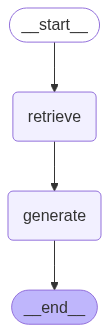

In [32]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### (중요)
병렬처리나 `conditional_edge`가 없는 경우 `add_sequence()`를 통해 순차적으로 동작하는 그래프를 생성할 수 있음

In [33]:
sequence_graph_builder = StateGraph(AgentState).add_sequence([retrieve, generate])

In [34]:
sequence_graph_builder.add_edge(START, "retrieve")
sequence_graph_builder.add_edge("generate", END)

In [35]:
sequence_graph = sequence_graph_builder.compile()

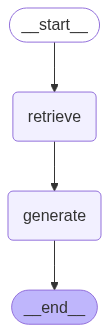

In [36]:
display(Image(sequence_graph.get_graph().draw_mermaid_png()))

In [37]:
initial_state = {"query": query}
graph.invoke(initial_state)

{'query': '연봉 5천만원 직장인의 소득세는?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='소득세법\n\n근로자 또는 배우자의 해당 과세기간 개시일을 기준으로 6세 이하(아래와 같이 해당가 되는 날과 그 이전 기간을 말함)인 아동의 보육과 관련하여 사용자가 제공하는 급여의 월 20만원 이내의 금액\n국고로부터 송출 및 대금 5%에 관한 법률에 의한 보육비 등 받은 보조 및 퇴직임금으로, 교육기본법, 제28조제1항에 따른 장학금 중 대학생의 근로를 대가로 지급받는 장학금(고등교육법), 제20조제1항부터 제4항까지 규정에 따라 대학에 재학하는 대학생에 한정한다.\n대책이동법, 제20조제1항에 따른 중복임금(아래의 조, 제20조 및 제21조에서 “중복임금”이라 한다)과 연계된 사용자(이하 “사용자”라 한다)로부터 받는 보상금. 다만, 보상금을 지급한 사용자가 대책법으로 정하는 특수관계에 있는 자가 받는 보상금은 제외한다.\n대학교의 교직원 또는 대학의 고용관계에 있는 학생이 소속 대학교에 설치한 산업교육진흥 및 산업학연계촉진에 관한 법률 제21조에 따라 산학협력단(이하 “산학협력단”이라 한다)으로부터 받은 제20조제1항 제3호에 따른 받은 보상금\n대책법령으로 정하는 복리후생적 성실의 급여\n제20조제1항제3호에 따른 소득 중 다음의 요건 모두 충족하는 소득으로서 대책법령으로 정하는 금액 이하의 금액\n\n임원 또는 종업원(이하 이 조, 제20조 및 제21조에서 “임원”이라 한다)이 본인이 소비하는 것을 목적용으로 제공받거나 지원을 받아 구입할 재화 또는 용역으로서 대책법령으로 정하는 기간 동안 재판매가 더 없도록 함\n\n\n여론조사 중 다음 각 목의 어느 하나에 해당하는 소득\n\n구인연금법, 공무원연금법, 또는 구인연금법이 제정하는 정규직 및 구직 곤란을 겪는 근로자의 교직원 연금, 위탁정기확립법, 또는 구인연금법의 연계에 관한 법령(이하 